Import necessary libraries

In [18]:
import os
import numpy as np
import rasterio
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

This bloc served the purpose of visualizing the data and understand it's formatting. It can be skipped.

File: RASTER_9.tif | Shape: (4, 2816, 2816)
Image shape: (4, 2816, 2816)
Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2816, 'height': 2816, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 22S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32722"]]'), 'transform': Affine(10.0, 0.0, 408149.987497736,
       0.0, -10.0, 9364500.00147435), 'blockxsize': 2816, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


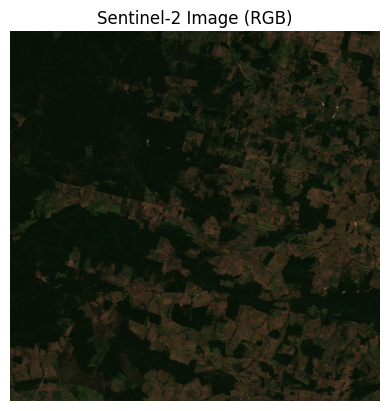

File: RASTER_8.tif | Shape: (4, 2816, 2816)
Image shape: (4, 2816, 2816)
Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2816, 'height': 2816, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 22S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32722"]]'), 'transform': Affine(10.0, 0.0, 379989.987497736,
       0.0, -10.0, 9364500.00147435), 'blockxsize': 2816, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


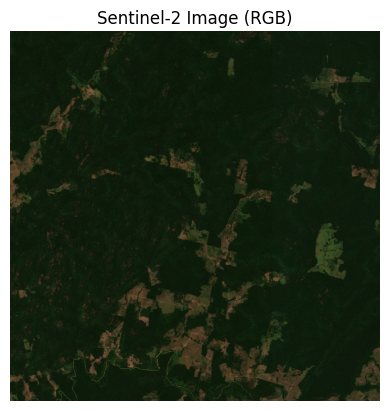

File: RASTER_0.tif | Shape: (4, 2816, 2816)
Image shape: (4, 2816, 2816)
Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2816, 'height': 2816, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 22S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32722"]]'), 'transform': Affine(10.0, 0.0, 379989.987497736,
       0.0, -10.0, 9420820.00147435), 'blockxsize': 2816, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


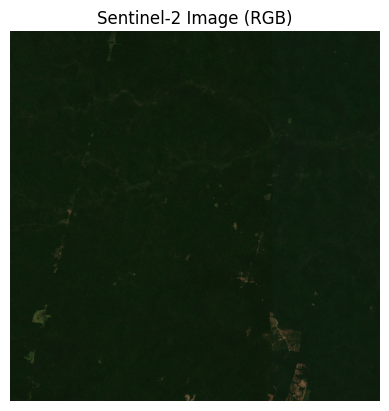

In [4]:
import os


folder_path = "dataset/deforestation-detection-dataset/1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID/"

tif_files = [f for f in os.listdir(folder_path) if f.endswith(".tif")]

# Loop through the first 3 images
for tif_file in tif_files[:3]:
    tif_path = os.path.join(folder_path, tif_file)
    
    with rasterio.open(tif_path) as dataset:
        image = dataset.read()
        profile = dataset.profile 
        print(f"File: {tif_file} | Shape: {image.shape}")


# Check the image's shape (Bands, Height, Width)
        print(f"Image shape: {image.shape}")  
        print(f"Metadata: {profile}")

        # If the image has multiple bands, extract RGB (Sentinel-2: Bands 4,3,2)
        if image.shape[0] >= 3:
            rgb_image = np.stack([image[2], image[1], image[0]], axis=-1)  # RGB format
        else:
            rgb_image = image[0]  # grayscale

        # Normalize
        rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

        plt.imshow(rgb_image)
        plt.title("Sentinel-2 Image (RGB)")
        plt.axis("off")
        plt.show()


This bloc served the purpose of visualizing the masks and understand it's formatting. It can be skipped.

Available Mask Files: ['RASTER_9.tif', 'RASTER_8.tif', 'RASTER_0.tif', 'RASTER_1.tif', 'RASTER_3.tif']
Mask shape: (2816, 2816), Data Type: uint8


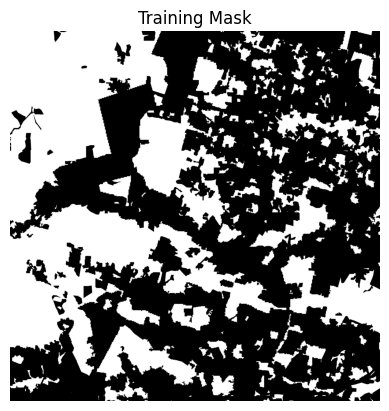

In [ ]:

masks_folder = "dataset/deforestation-detection-dataset/3_TRAINING_MASKS/MASK_16_GRID/"

# List available mask files
mask_files = [f for f in os.listdir(masks_folder) if f.endswith(".tif")]
print("Available Mask Files:", mask_files[:5]) 

# Select one mask file to visualize
sample_mask_path = "dataset/deforestation-detection-dataset/3_TRAINING_MASKS/MASK_16_GRID/RASTER_9.tif"

# Open and display the mask
with rasterio.open(sample_mask_path) as dataset:
    mask = dataset.read(1)  
    print(f"Mask shape: {mask.shape}, Data Type: {mask.dtype}")

# Normalize the mask for display 
mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))


plt.imshow(mask, cmap="gray")
plt.title("Training Mask")
plt.axis("off")
plt.show()


This method allows to resize the image and mask so the data is better suited to be used by the model. Only the RGB bands are kept for the image and the mask datais converted to binary.

In [5]:
def preprocess_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    """Loads a Sentinel-2 image and its corresponding mask, resizes them, and normalizes values."""
    
    # Load the image from the input path
    with rasterio.open(image_path) as img_dataset:
        image = img_dataset.read()  
        rgb_image = np.stack([image[2], image[1], image[0]], axis=-1)  # Extract RGB bands
    
    # Resize the image
    rgb_image = cv2.resize(rgb_image, target_size)
    rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))


    # Load the corresponding mask
    with rasterio.open(mask_path) as mask_dataset:
        mask = mask_dataset.read(1)  # Read first band
    
    # Resize the mask and convert values to binary (Invert the mask so 1 = deforested, 0 = forest)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    mask = (mask - 1).astype(np.uint8)  # Convert 1 → 0 (Forest), 2 → 1 (Deforested)


    return rgb_image, mask


This method ensures all the images and masks have been preprocessed beforecontinuing forward. The processed data is added to np.arrays that will be used from this point forward.

In [6]:
def preprocess_dataset():
    """Reads Sentinel-2 images & masks, applies preprocessing, and returns NumPy arrays."""
    
    images, masks = [], []
    target_size=(256, 256)
    image_folder = "dataset/deforestation-detection-dataset/1_CLOUD_FREE_DATASET/2_SENTINEL2/IMAGE_16_GRID/"
    mask_folder = "dataset/deforestation-detection-dataset/3_TRAINING_MASKS/MASK_16_GRID/"
    
    # Get the list of all Sentinel-2 images
    image_files = [f for f in os.listdir(image_folder) if f.endswith(".tif")]
    
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, img_file) 
        
        if not os.path.exists(mask_path):
            print(f"Skipping {img_file}: No matching mask found.")
            continue
        
        img, mask = preprocess_image_and_mask(img_path, mask_path, target_size)
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


The test method ensure the testing hasn't caused any new issues.

In [7]:
# PREPROCESSING METHODS TEST

import matplotlib.pyplot as plt
import numpy as np

def test_preprocessing():
    """Tests preprocess_dataset() by checking image and mask outputs."""
    
    X, y = preprocess_dataset()

    # Print the dataset details
    print(f"Dataset Loaded: {X.shape[0]} images, {y.shape[0]} masks")
    print(f"Image shape: {X.shape[1:]}, Mask shape: {y.shape[1:]}")

    # Check the normalization range for images
    print(f"Image Min-Max Values: {X.min()} - {X.max()}")  # Should be between 0 and 1

    # Check the unique values in masks (should be only [0,1])
    unique_values = np.unique(y)
    print(f"Unique Mask Values: {unique_values}")  

    # Assert that only 0 and 1 exist in masks
    assert set(unique_values).issubset({0, 1}), "Error: Mask contains unexpected values!"

    return X, y

# Run the test
X , y = test_preprocessing()


Dataset Loaded: 16 images, 16 masks
Image shape: (256, 256, 3), Mask shape: (256, 256)
Image Min-Max Values: 0.0 - 1.0
Unique Mask Values: [0 1]


This function separates the data into testing and training data for the model's future use.

In [28]:

def split_dataset(X, y, test_size=0.2, random_state=42):
    """Splits the dataset into training and testing sets."""
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    print(f"Training masks: {y_train.shape}, Testing masks: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

# Call function to split the dataset
X_train, X_test, y_train, y_test = split_dataset(X, y)

Training set: (12, 256, 256, 3), Testing set: (4, 256, 256, 3)
Training masks: (12, 256, 256), Testing masks: (4, 256, 256)


In [8]:
def split_dataset(X, y, test_size=0.2, val_size=0.1, random_state=42):
    """Splits the dataset into training, validation, and testing sets."""

    # First, split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Further split training set into training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=random_state
    )

    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Testing set: {X_test.shape}")
    print(f"Training masks: {y_train.shape}, Validation masks: {y_val.shape}, Testing masks: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Call function to split the dataset
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y, test_size=0.2, val_size=0.1)

Training set: (10, 256, 256, 3), Validation set: (2, 256, 256, 3), Testing set: (4, 256, 256, 3)
Training masks: (10, 256, 256), Validation masks: (2, 256, 256), Testing masks: (4, 256, 256)


This method converts the dataset in NumPy array to a tensorflow dataset, applies augmentation to the training data and batches it.

In [9]:
def prepare_tf_dataset(X, y, batch_size=8):
    """Applies data augmentation and prepares dataset for training."""
    
    # Define an ImageDataGenerator for augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip images randomly
        tf.keras.layers.RandomRotation(0.1),  # Rotate slightly
        tf.keras.layers.RandomZoom(0.2),  # Zoom in/out
    ])

    # Convert data in NumPy arrays to a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    # Apply the augmentation method only to the training images
    dataset = dataset.map(lambda img, mask: (data_augmentation(img), mask))

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Recreate datasets with augmentation
train_dataset = prepare_tf_dataset(X_train, y_train, batch_size=8)
val_dataset = prepare_tf_dataset(X_val, y_val, batch_size=8)
test_dataset = prepare_tf_dataset(X_test, y_test, batch_size=8)


print(train_dataset)
print(val_dataset)
print(test_dataset)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.uint8, name=None))>


Validate the previous method is working

In [10]:
# Print first batch to verify structure
for img_batch, mask_batch in train_dataset.take(1):  # Take one batch
    print(f"Image batch shape: {img_batch.shape}")
    print(f"Mask batch shape: {mask_batch.shape}")


Image batch shape: (8, 256, 256, 3)
Mask batch shape: (8, 256, 256)


2025-03-19 11:58:20.958666: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


MODEL BUILDING ITERATION 1
This was the first attempt at getting/building the deeplabv3+ model. It failed because deeplab is not available as a decoder. 

In [48]:
from official.vision.modeling.backbones import resnet
from official.vision.modeling.decoders import deeplab
from official.vision.modeling.heads import segmentation_heads

def build_deeplabv3(input_shape=(256, 256, 3), num_classes=1):
    """Builds DeepLabV3+ using TensorFlow Model Garden."""
    
    # Define the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Load a ResNet backbone (can be changed to MobileNet for efficiency)
    backbone = resnet.ResNet(model_id=50, output_stride=16)
    
    # Create the DeepLabV3+ decoder
    decoder = deeplab.DeepLabV3Plus(output_stride=16)

    # Apply backbone & decoder to the input
    x = backbone(inputs)
    x = decoder(x)

    # Add segmentation head with a final activation function
    segmentation_head = segmentation_heads.SegmentationHead(num_classes=num_classes, activation="sigmoid")
    outputs = segmentation_head(x)

    # Define model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
model = build_deeplabv3()

# Print model summary
model.summary()

ImportError: cannot import name 'deeplab' from 'official.vision.modeling.decoders' (/Users/leannericard/Downloads/U3/U3.2/AI Bootcamp/forestwatch-ai/venv/lib/python3.12/site-packages/official/vision/modeling/decoders/__init__.py)

Proves deeplab is not in decoders.

In [35]:
import official.vision.modeling.decoders as decoders
print(dir(decoders)) 

['ASPP', 'FPN', 'NASFPN', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'aspp', 'factory', 'fpn', 'nasfpn']


### **DeepLabV3+ Model for Deforestation Detection**
This block builds the **DeepLabV3+ model**, a deep learning network designed to detect deforested areas in satellite images.

#### How It Works
- **ResNet-50 Backbone**: Extracts important features from the input image.
- **ASPP Module**: Looks at different levels of detail to detect patterns at multiple scales.
- **Segmentation Head**: Refines the features and **upsamples the image back to its original size** for pixel-level classification.
- **Final Layer**: Outputs a **binary mask** where:
  - **0 = Forest**
  - **1 = Deforested**

####  Training Setup
- **Adam optimizer** adjusts the model as it learns.
- **Binary crossentropy loss** helps improve predictions.
- **Dropout (0.3)** prevents overfitting so the model generalizes better.

#### Goal
The model takes **Sentinel-2 images** and outputs a **map showing deforested areas**, helping track environmental changes.

In [ ]:
from tensorflow.keras import layers, Model

def ASPP(inputs):
    """Atrous Spatial Pyramid Pooling (ASPP) module for DeepLabV3+."""
    dims = inputs.shape[-1]

    # Apply different atrous rates
    pool = layers.GlobalAveragePooling2D()(inputs)
    pool = layers.Reshape((1, 1, dims))(pool)
    pool = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(pool)
    pool = layers.BatchNormalization()(pool)
    pool = layers.Activation("relu")(pool)
    pool = layers.UpSampling2D(size=(inputs.shape[1], inputs.shape[2]), interpolation="bilinear")(pool)

    conv_1x1 = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(inputs)
    conv_1x1 = layers.BatchNormalization()(conv_1x1)
    conv_1x1 = layers.Activation("relu")(conv_1x1)

    conv_3x3_1 = layers.Conv2D(256, (3, 3), dilation_rate=6, padding="same", use_bias=False)(inputs)
    conv_3x3_1 = layers.BatchNormalization()(conv_3x3_1)
    conv_3x3_1 = layers.Activation("relu")(conv_3x3_1)

    conv_3x3_2 = layers.Conv2D(256, (3, 3), dilation_rate=12, padding="same", use_bias=False)(inputs)
    conv_3x3_2 = layers.BatchNormalization()(conv_3x3_2)
    conv_3x3_2 = layers.Activation("relu")(conv_3x3_2)

    conv_3x3_3 = layers.Conv2D(256, (3, 3), dilation_rate=18, padding="same", use_bias=False)(inputs)
    conv_3x3_3 = layers.BatchNormalization()(conv_3x3_3)
    conv_3x3_3 = layers.Activation("relu")(conv_3x3_3)

    # Concatenate all branches
    x = layers.Concatenate()([pool, conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3])
    x = layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def build_deeplabv3(input_shape=(256, 256, 3), num_classes=1):
    """Builds DeepLabV3+ using a ResNet-50 backbone and ASPP module."""
    
    # Load ResNet-50 as the feature extractor (backbone)
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
    backbone = Model(inputs=base_model.input, outputs=base_model.get_layer("conv4_block6_out").output)

    # Apply ASPP
    aspp_output = ASPP(backbone.output)

    # Final segmentation head
    x = layers.Conv2D(256, (3, 3), padding="same", use_bias=False)(aspp_output)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Add dropout before final upsampling
    x = layers.Dropout(0.3)(x)  # 30% of neurons will be turned off randomly
    x = layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(x) # Upsample back to input size
    x = layers.Conv2D(num_classes, (1, 1), activation="sigmoid", padding="same")(x)  # Binary segmentation output

    # Define the final model
    model = Model(inputs=backbone.input, outputs=x)
    return model

# Build the model
model = build_deeplabv3()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

# Print model summary
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 17,116,289 (65.29 MB)

 Trainable params: 17,082,113 (65.16 MB)

 Non-trainable params: 34,176 (133.50 KB)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# MODEL V2
def ASPP(inputs):
    """Simplified ASPP module with fewer filters and dilation rates to reduce complexity."""
    dims = inputs.shape[-1]

    pool = layers.GlobalAveragePooling2D()(inputs)
    pool = layers.Reshape((1, 1, dims))(pool)
    pool = layers.Conv2D(128, (1, 1), padding="same", use_bias=False)(pool)
    pool = layers.BatchNormalization()(pool)
    pool = layers.Activation("relu")(pool)
    pool = layers.UpSampling2D(size=(inputs.shape[1], inputs.shape[2]), interpolation="bilinear")(pool)

    conv_1x1 = layers.Conv2D(128, (1, 1), padding="same", use_bias=False)(inputs)
    conv_1x1 = layers.BatchNormalization()(conv_1x1)
    conv_1x1 = layers.Activation("relu")(conv_1x1)

    conv_3x3_1 = layers.Conv2D(128, (3, 3), dilation_rate=6, padding="same", use_bias=False)(inputs)
    conv_3x3_1 = layers.BatchNormalization()(conv_3x3_1)
    conv_3x3_1 = layers.Activation("relu")(conv_3x3_1)

    # Concatenate fewer branches for simplicity
    x = layers.Concatenate()([pool, conv_1x1, conv_3x3_1])
    x = layers.Conv2D(128, (1, 1), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def build_deeplabv3(input_shape=(256, 256, 3), num_classes=1):
    """Builds DeepLabV3+ with a smaller backbone and regularization techniques."""
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")
    backbone = Model(inputs=base_model.input, outputs=base_model.get_layer("block_13_expand_relu").output)

    aspp_output = ASPP(backbone.output)

    # Final segmentation head with higher dropout
    x = layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(aspp_output)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(x)
    x = layers.Conv2D(num_classes, (1, 1), activation="sigmoid", padding="same")(x)

    model = Model(inputs=backbone.input, outputs=x)
    return model

# Build the model
model = build_deeplabv3()

# Dice Loss function
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 - (2. * intersection + smooth) / (union + smooth)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=dice_loss,  # Switching to Dice Loss
    metrics=["accuracy"]
)

model.summary()


/var/folders/ks/8t5yvpw115d1nwflqk0b3zwh0000gn/T/ipykernel_48915/1778241388.py:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 1,626,689 (6.21 MB)

 Trainable params: 1,608,129 (6.13 MB)

 Non-trainable params: 18,560 (72.50 KB)

In [ ]:
# Loading a saved model
model = tf.keras.models.load_model("deeplabv3_deforestation.keras")


/Users/leannericard/Downloads/U3/U3.2/AI Bootcamp/forestwatch-ai/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 197 variables whereas the saved optimizer has 392 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Here's where the mdoel is trained with a set number of epochs, learning rate and batch size. The output is printed to be able to follow the model'S progess.

In [12]:
# Set training hyperparameters
EPOCHS = 20  # Number of times the model sees the full dataset
BATCH_SIZE = 8  # Same as what we used for data preprocessing
LEARNING_RATE = 0.0005  # Controls how much the model updates weights each step

# Define an optimizer with the selected learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    verbose=1  # Shows progress during training
)


Epoch 1/20


KeyboardInterrupt: 

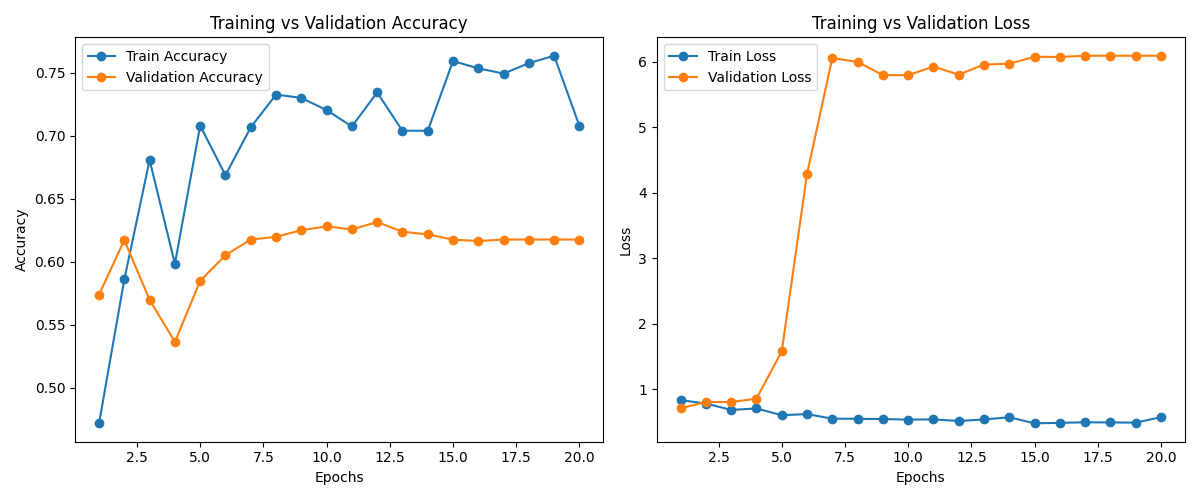

In [58]:
import matplotlib.pyplot as plt

# Define epoch range
epochs = list(range(1, 21))

# Training and validation accuracy
train_accuracy = [0.4716, 0.5859, 0.6807, 0.5983, 0.7081, 0.6687, 0.7067, 0.7327, 0.7301, 0.7204,
                  0.7074, 0.7344, 0.7040, 0.7040, 0.7593, 0.7536, 0.7494, 0.7577, 0.7636, 0.7078]
val_accuracy = [0.5738, 0.6172, 0.5697, 0.5363, 0.5848, 0.6052, 0.6176, 0.6197, 0.6250, 0.6280,
                0.6256, 0.6315, 0.6238, 0.6217, 0.6175, 0.6164, 0.6176, 0.6176, 0.6176, 0.6176]

# Training and validation loss
train_loss = [0.8334, 0.7806, 0.6842, 0.7055, 0.6032, 0.6194, 0.5504, 0.5478, 0.5441, 0.5352,
              0.5392, 0.5143, 0.5377, 0.5718, 0.4786, 0.4864, 0.4946, 0.4925, 0.4893, 0.5729]
val_loss = [0.7070, 0.8059, 0.8039, 0.8561, 1.5781, 4.2879, 6.0604, 6.0008, 5.7997, 5.7979,
            5.9296, 5.8062, 5.9605, 5.9739, 6.0794, 6.0770, 6.0955, 6.0956, 6.0956, 6.0956]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axes[0].plot(epochs, train_accuracy, label="Train Accuracy", marker="o")
axes[0].plot(epochs, val_accuracy, label="Validation Accuracy", marker="o")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy")
axes[0].legend()

# Plot training and validation loss
axes[1].plot(epochs, train_loss, label="Train Loss", marker="o")
axes[1].plot(epochs, val_loss, label="Validation Loss", marker="o")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss")
axes[1].legend()

# Save the figure
plt.tight_layout()
plt.savefig("training_results.png")  # Saves graph as an image in your working directory

# If using Jupyter Notebook, display the image after saving
from IPython.display import display
from PIL import Image
display(Image.open("training_results.png"))


Hyperparametr tuning method

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_model(hp):
    """Builds a model with tunable hyperparameters."""
    
    # Define tunable hyperparameters
    learning_rate = hp.Choice('learning_rate', [0.0001, 0.0005, 0.001])  # Tune LR
    dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)  # Tune Dropout
    
    # Load ResNet-50 as the backbone
    base_model = tf.keras.applications.ResNet50(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
    backbone = Model(inputs=base_model.input, outputs=base_model.get_layer("conv4_block6_out").output)

    # Apply ASPP (same as your original code)
    aspp_output = ASPP(backbone.output)

    # Final segmentation head
    x = layers.Conv2D(256, (3, 3), padding="same", use_bias=False)(aspp_output)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)  # Tunable dropout
    x = layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(x)
    x = layers.Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)

    model = Model(inputs=backbone.input, outputs=x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )

    return model

# Define Keras Tuner search
tuner = kt.Hyperband(
    build_model, 
    objective="val_accuracy",
    max_epochs=10,  # Short epochs to test quickly
    factor=3, 
    directory="keras_tuner_results", 
    project_name="deforestation_segmentation"
)

# Run the search on the validation set
tuner.search(train_dataset, validation_data=val_dataset, epochs=10)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
print(f"Best Dropout Rate: {best_hps.get('dropout')}")

# Train final model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(train_dataset, validation_data=val_dataset, epochs=20)


Reloading Tuner from keras_tuner_results/deforestation_segmentation/tuner0.json
Best Learning Rate: 0.001
Best Dropout Rate: 0.2


AttributeError: module 'keras.api.applications' has no attribute 'ResNet18'

In [24]:
# Saving a trained model
model.save("deeplabv3_deforestationV2.keras")
# Save the trained model weights
model.save_weights("trained_modelV2.weights.h5")
